やりたいこと

・引ける牌の確率が変わったとき（手牌にある牌はその分引きづらくなるとか）のvalueを求める

・18種や27種（マンズだけでなく、ピンズやソーズも増やす）時のvalueを求める

面倒なので、まずは最大でも１色とする(n<=9)、手牌は14枚以下(m=3, 5, 8, 11, 14のみ)、同一牌は4枚(l = 4)でこれは固定。この条件でvalueを求める。



 **変数の意味**

- state : あがりに必要な枚数の手牌の状態

- hand : stateから一枚切った状態

### 必要な関数の再定義

In [0]:
from collections import defaultdict
def is_valid(seq, l=4): # 生成された組み合わせが手牌として妥当かどうかを判断する関数　tuple(seq)の一つ一つが一つの状態(手牌)に対応している
    counts = defaultdict(lambda: 0)
    for i in range(0, len(seq)):
        if i + 1 < len(seq) and seq[i] > seq[i + 1]: # 前半の条件はiが一番最後以外は常に成立、後半の条件は昇順に整列するための条件
            return False
        counts[seq[i]] += 1
        if (counts[seq[i]] > l): return False # 牌の上限枚数を超えたらFalse
    return True

import itertools
def number_state_slow(n,m,l): # 全ての手牌の組み合わせの数を出力する関数
    count = 0
    for seq in itertools.product(range(n), repeat = m): # 直積を作る関数, n=9 m=5 なら 9 ** 5 回繰り返す　
        if is_valid(seq,l):
            count += 1
            #print(list(seq))
    return count
    
def generate_all_l(n, m, l=4): # 全ての手牌の組み合わせをタプルで出力する関数
    gen_list = []
    for seq in itertools.product(range(n), repeat = m):
        if is_valid(seq, l):
            gen_list.append(seq)
    return gen_list

def states_to_hist(state_list, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist_list = []
    for state in state_list:
        #print(state)
        ret = [0] * n # ret = [0,0,...,0]
        for c in state:
            ret[c] += 1
        hist_list.append(ret)
    return hist_list

def hand_to_prob_and_state(hand, state_nml, n, m, l=4): # ある手牌(hand)における、1枚ツモる時の遷移確率(prob)と手牌(state)のindexのタプルを出す関数
    #print(state_nml)
    ret = [l] * n  #  残り枚数を表すリスト
    for h in hand:
        ret[h] -= 1
    yama_sum = n * l - (m - 1)
    state_list = []
    for i in range(n):
        if ret[i] == 0: 
            continue
        prob = ret[i] / yama_sum # 遷移確率
        state = tuple(sorted(list(hand) + [i])) # 遷移後の手牌
        #print(state)
        state_index = state_nml.index(state) # 遷移後の手牌のindex
        #print(state_index)
        state_list.append((prob, state_index))
    return state_list

def state_to_hand(state): # ある手牌stateに遷移できるhandを出力する関数
    return list(set(tuple(state[:i] + state[i+1:]) for i in range(len(state)))) # i番目の要素を取り除く

def is_win_sub(hist, two, three):
    if any(x < 0 for x in hist):
        return False # この行を消したかったら、順子判定のところで手牌の枚数が負になるものを弾いておく
    if two == 0 and three == 0:
        return True
    i = next(i for i, x in enumerate(hist) if x > 0) # histの中でx>０を満たす最小のindexを持ってくる
    if two > 0 and hist[i] >= 2 and is_win_sub([x - 2 if i == j else x for j, x in enumerate(hist)], two - 1, three): # 雀頭
        return True
    if three > 0 and hist[i] >= 3 and is_win_sub([x - 3 if i == j else x for j, x in enumerate(hist)], two, three - 1): # 刻子
        return True
    if three > 0 and i + 2 < len(hist) and is_win_sub([x -1 if i <= j <= i + 2 else x for j, x in enumerate(hist)], two, three - 1): # 順子
        return True
    return False

def is_win_main(hist):
    n_two = 1 if sum(hist) % 3 == 2 else 0
    n_three = sum(hist) // 3
    return is_win_sub(hist, n_two, n_three)

def value_iteration(n, m, l, gamma):
    state_nml = generate_all_l(n, m, l)
    hand_nml = generate_all_l(n, m-1, l)
    hist_nml = states_to_hist(state_nml, n)
    is_win_nml = [is_win_main(hist) for hist in hist_nml]
    h2ps_nml = [hand_to_prob_and_state(hand, state_nml, n, m, l) for hand in hand_nml]
    s2h_nml = [[hand_nml.index(hand) for hand in state_to_hand(state)] for state in state_nml]
    value_hand = [0] * len(hand_nml)
    n_hand = len(hand_nml)
    value_state = [1 if is_win_nml[i] else 0 for i in range(len(state_nml))] # あがっていればvalueは1、いなければ0
    n_state = len(state_nml)
    theta = 1e-6
    while True:
        print('iteration')
        delta = 0
        for i in range(n_hand):
            old_v = value_hand[i]
            value_hand[i] = sum(p * value_state[n] for (p, n) in h2ps_nml[i])
            delta = max(delta, abs(old_v - value_hand[i]))
        if delta < theta: break
        for i in range(n_state):
            if is_win_nml[i]: continue
            value_state[i] = max(gamma * value_hand[n] for n in s2h_nml[i])
    return value_hand

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from tensorflow.keras import layers

random_seed = 34
np.random.seed(random_seed)
tf.set_random_seed(random_seed)

In [0]:
def one_hot_vector1(hands, n): # 手牌の中の牌一つ一つをone-hotにした(手牌１つがn * m-1の行列に対応)
    results = np.zeros((len(hands), n, len(hands[0])))
    for i in range(len(hands)):
        for j, hand_i in enumerate(hands[i]):
            results[i][hand_i][j] = 1
    return results

def one_hot_vector3(hists, n, l=4): # histをそのままone-hotにした(手牌１つがn * l + 1の行列に対応)
    results = np.zeros((len(hists), n, l + 1))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            results[i][j][hist_i] = 1
    return results

def one_hot_vector4(hists, n, l=4): # 上に近いけど、持ってる枚数より小さい数も1で埋めた(手牌１つがn * lの行列に対応)
    results = np.zeros((len(hists), n, l))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            if hist_i == 0:
                continue
            else:
                results[i][j][:hist_i] = 1
    return results

### 捨て牌ベクトルの作成

In [13]:
n = 9
m = 5
l = 4

value_hand_nml = value_iteration(n, m, l, 0.9)
state_nml = generate_all_l(n, m, l)
hand_nml = generate_all_l(n, m - 1, l)
#print(len(hand_nml))
#print(hand_nml)

def state_to_hist(state, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist = [0] * n # hist = [0,0,...,0]
    for c in state:
        hist[c] += 1
    return hist

#stateのindexと、そのstate時にvalueが最大となる手牌のリスト
def states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l=4):
    max_value_list = []
    discard_state_nml = []
    hist_nml = states_to_hist(state_nml, n)
    for i, hist in enumerate(hist_nml):        
        if is_win_main(hist):
            continue # あがっているstateの時は何も入れない
        else:
            max_value = 0
            max_p = []
            for j in range(m):
                state = state_nml[i]
                hand = state[:j] + state[j+1:]
                ind = hand_nml.index(tuple(hand))
                hand_val = value_hand_nml[ind]
                if max_value < hand_val:
                    max_p = {state[j]}
                    max_value = hand_val
                elif round(max_value, 5) == round(hand_val, 5): # 小数点以下5桁まで同じなら同じとみなす
                    max_p.add(state[j])
            discard_state_nml.append(state_nml[i])
            max_value_list.append(tuple((i, max_p)))
    return max_value_list, discard_state_nml # 正直discard_hist_nmlを出す方が早い

def one_hot_discard_vector(max_value_discard_list, n, m, l):
    discard_vector = []
    for i, discard in max_value_discard_list:
        v = [0] * n
        num = len(discard)
        for p in discard:
            v[p] = 1 / num # 答えの数で割った値を教師とする  こうしないと学習がうまくいかない
            #v[p] = 1
        discard_vector.append(v)
    return discard_vector

max_value_discard_list, discard_state_nml = states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l)
discard_hist_nml = states_to_hist(discard_state_nml, n)

one_hot_discard_state_nml1 = one_hot_vector1(discard_state_nml, n)
one_hot_discard_state_nml3 = one_hot_vector3(discard_hist_nml, n, l)
one_hot_discard_state_nml4 = one_hot_vector4(discard_hist_nml, n, l)
discard_vector_nml = np.array(one_hot_discard_vector(max_value_discard_list, n, m, l))

iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [14]:
for i in range(len(discard_state_nml)):
    print('discard_state_nml {} max_value_discard_list {} discard_vector {}'.format(discard_state_nml[i], max_value_discard_list[i], discard_vector_nml[i]))

discard_state_nml (0, 0, 0, 0, 1) max_value_discard_list (0, {0}) discard_vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]
discard_state_nml (0, 0, 0, 0, 2) max_value_discard_list (1, {0}) discard_vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]
discard_state_nml (0, 0, 0, 0, 3) max_value_discard_list (2, {0}) discard_vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]
discard_state_nml (0, 0, 0, 0, 4) max_value_discard_list (3, {0}) discard_vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]
discard_state_nml (0, 0, 0, 0, 5) max_value_discard_list (4, {0}) discard_vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]
discard_state_nml (0, 0, 0, 0, 6) max_value_discard_list (5, {0}) discard_vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]
discard_state_nml (0, 0, 0, 0, 7) max_value_discard_list (6, {0}) discard_vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]
discard_state_nml (0, 0, 0, 0, 8) max_value_discard_list (7, {0}) discard_vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]
discard_state_nml (0, 0, 0, 1, 3) max_value_discard_list (10, {3}) discard_vector [0. 0. 0. 1. 0. 0. 0. 0. 0.]
discard_s

In [15]:
for i, j in enumerate(value_hand_nml):print(hand_nml[i], j)

(0, 0, 0, 0) 0.623206603954413
(0, 0, 0, 1) 0.7368417110704681
(0, 0, 0, 2) 0.7457427040209905
(0, 0, 0, 3) 0.6741649121626253
(0, 0, 0, 4) 0.6835351062379332
(0, 0, 0, 5) 0.6835351062379332
(0, 0, 0, 6) 0.6835351062379331
(0, 0, 0, 7) 0.6710901189682166
(0, 0, 0, 8) 0.6611703650638596
(0, 0, 1, 1) 0.6373157819031039
(0, 0, 1, 2) 0.697672554999759
(0, 0, 1, 3) 0.6696701820888531
(0, 0, 1, 4) 0.6216001018868548
(0, 0, 1, 5) 0.6261492846181727
(0, 0, 1, 6) 0.6310454046118992
(0, 0, 1, 7) 0.6074479052422226
(0, 0, 1, 8) 0.5882351219806399
(0, 0, 2, 2) 0.6653798770865167
(0, 0, 2, 3) 0.7692306920496034
(0, 0, 2, 4) 0.6749564784225439
(0, 0, 2, 5) 0.6404933180467028
(0, 0, 2, 6) 0.6451145793443589
(0, 0, 2, 7) 0.6278409871371761
(0, 0, 2, 8) 0.612816881162645
(0, 0, 3, 3) 0.681370174245883
(0, 0, 3, 4) 0.7692306920496034
(0, 0, 3, 5) 0.6815710394491212
(0, 0, 3, 6) 0.6496761208585917
(0, 0, 3, 7) 0.6338489254677317
(0, 0, 3, 8) 0.6195848503557301
(0, 0, 4, 4) 0.6813701742458829
(0, 0, 4, 5)

### Policy networkの作成

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 45)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 30)                1380      
_________________________________________________________________
dense_25 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_26 (Dense)             (None, 9)                 99        
Total params: 1,789
Trainable params: 1,789
Non-trainable params: 0
_________________________________________________________________
2.1367374050544212
......................................................................................................................................................0.39942027754879583
.............................................................

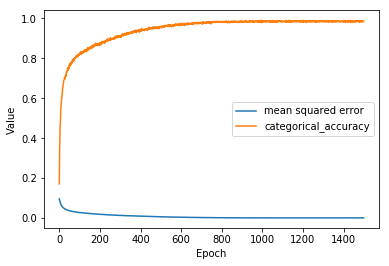

In [32]:
# one_host_hand_nml1
def build_model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(n, m)),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='relu'),
        #layers.Dense(15, activation='relu'),
        layers.Dense(n, activation='softmax'),
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mean_squared_error', 'categorical_accuracy'])
    return model

model = build_model()
model.summary()

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
  
    def on_epoch_end(self, epoch, logs):
        if epoch % (self.epochs // 10) == 0: print(logs.get('loss'))
        print('.', end='')

EPOCHS = 1500

history = model.fit(one_hot_discard_state_nml1, discard_vector_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot(EPOCHS)])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n',hist.tail())

import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    #plt.plot(hist['epoch'], hist['mean_absolute_error'], label='mean absolute error')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label = 'mean squared error')
    plt.plot(hist['epoch'], hist['categorical_accuracy'], label='categorical_accuracy')
    plt.legend()

def plot_history_y(history, y_lim_max):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    #plt.plot(hist['epoch'], hist['mean_absolute_error'], label='mean absolute error')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label = 'mean squared error')
    plt.plot(hist['epoch'], hist['categorical_accuracy'], label='categorical_accuracy')
    plt.legend()
    plt.ylim(0, y_lim_max)

plot_history(history)

predictions1 = model.predict(one_hot_discard_state_nml1)

In [33]:
for i, state in enumerate(discard_state_nml):
    pr = [round(j, 3) for j in predictions1[i]]
    print('state {}  true vector {}  predict vector {}'.format(state,  discard_vector_nml[i], pr))

state (0, 0, 0, 0, 1)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 2)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 3)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 4)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 5)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 6)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 7)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 8)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [34]:
pr_arg_list = []

# 切れない牌が出ないようマスク
for i, state in enumerate(discard_state_nml):
    pra = np.argmax(predictions1[i])
    if pra not in max_value_discard_list[i][1]:
        print('wrong', end='        ')
    if pra not in state:
        raise Exception
    pr_arg_list.append(pra)
    print('state {}  predict tile {}  max_value_discard_list {}'.format(state, pra, max_value_discard_list[i][1]))

state (0, 0, 0, 0, 1)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 2)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 3)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 4)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 5)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 6)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 7)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 8)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 1, 3)  predict tile 3  max_value_discard_list {3}
state (0, 0, 0, 1, 4)  predict tile 4  max_value_discard_list {4}
state (0, 0, 0, 1, 5)  predict tile 5  max_value_discard_list {5}
state (0, 0, 0, 1, 6)  predict tile 6  max_value_discard_list {6}
state (0, 0, 0, 1, 7)  predict tile 7  max_value_discard_list {7}
state (0, 0, 0, 1, 8)  predict tile 8  max_value_discard_list {8}
state (0, 0, 0, 2, 3)  predict tile 0  max_value_discard_list {0}
state (0, 

In [0]:
def acc_score(predict_list): 
    tr_count = 0
    fal_count = 0
    for i, j in zip(predict_list, max_value_discard_list):
        #print(i, j)
        if i in j[1]:
            tr_count += 1
        else:
            fal_count += 1
    print('true count {}  false count {}'.format(tr_count, fal_count))
    print(tr_count / (tr_count + fal_count))

In [35]:
acc_score(pr_arg_list)

true count 1143  false count 0
1.0


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 45)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                1380      
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 279       
Total params: 1,659
Trainable params: 1,659
Non-trainable params: 0
_________________________________________________________________
2.1352641326966038
......................................................................................................................................................0.27824545086525243
......................................................................................................................................................0.14643076403117034
.......................

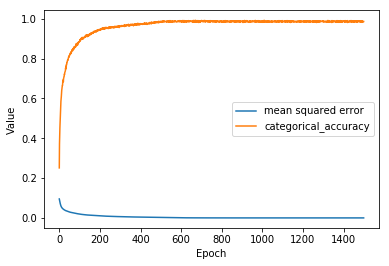

In [22]:
# one_host_hand_nml3
def build_model3():
    model = keras.Sequential([
        layers.Flatten(input_shape=(n, l + 1)),
        layers.Dense(30, activation='relu'),
        layers.Dense(n, activation='softmax'),
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mean_squared_error', 'categorical_accuracy'])
    return model

model = build_model3()
model.summary()

EPOCHS = 1500

history = model.fit(one_hot_discard_state_nml3, discard_vector_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot(EPOCHS)])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n',hist.tail())

plot_history(history)

predictions3 = model.predict(one_hot_discard_state_nml3)

In [23]:
for i, state in enumerate(discard_state_nml):
    pr = [round(j, 3) for j in predictions3[i]]
    print('state {}  true vector {}  predict vector {}'.format(state,  discard_vector_nml[i], pr))

state (0, 0, 0, 0, 1)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 2)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 3)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 4)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 5)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 6)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 7)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 8)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [25]:
pr_arg_list = []
for i, state in enumerate(discard_state_nml):
    pra = np.argmax(predictions3[i])
    if pra not in max_value_discard_list[i][1]:
        print('wrong', end='        ')
    if pra not in state:
        raise Exception
    pr_arg_list.append(pra)
    print('state {}  predict tile {}  max_value_discard_list {}'.format(state, pra, max_value_discard_list[i][1]))

state (0, 0, 0, 0, 1)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 2)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 3)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 4)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 5)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 6)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 7)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 0, 8)  predict tile 0  max_value_discard_list {0}
state (0, 0, 0, 1, 3)  predict tile 3  max_value_discard_list {3}
state (0, 0, 0, 1, 4)  predict tile 4  max_value_discard_list {4}
state (0, 0, 0, 1, 5)  predict tile 5  max_value_discard_list {5}
state (0, 0, 0, 1, 6)  predict tile 6  max_value_discard_list {6}
state (0, 0, 0, 1, 7)  predict tile 7  max_value_discard_list {7}
state (0, 0, 0, 1, 8)  predict tile 8  max_value_discard_list {8}
state (0, 0, 0, 2, 3)  predict tile 0  max_value_discard_list {0}
state (0, 

In [26]:
acc_score(pr_arg_list)

true count 1143  false count 0
1.0


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                740       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_20 (Dense)             (None, 9)                 99        
_________________________________________________________________
activation (Activation)      (None, 9)                 0         
Total params: 1,049
Trainable params: 1,049
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 O

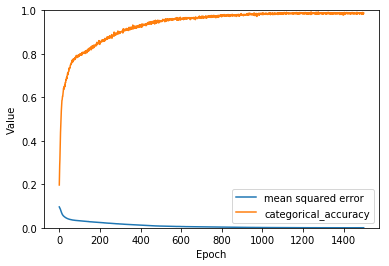

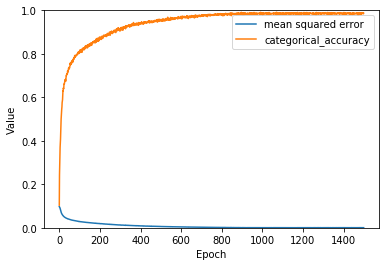

In [27]:
# one_host_hand_nml4
def build_dence_model(): # 比較のためのdenceモデル
    dence_model = keras.Sequential([
        layers.Flatten(input_shape=(n, l)),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu'),
        #layers.Dropout(rate=0.5),
        layers.Dense(n),
        layers.Activation('softmax')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    dence_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mean_squared_error', 'categorical_accuracy'])
    return dence_model

def build_cnn_model():
    cnn_model = keras.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same',  activation='relu', input_shape=(n, l)),
        #layers.Conv1D(filters=8, kernel_size=1, strides=1, padding='same',  activation='relu'),
        #layers.Dense(20, activation='relu'),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(n),
        layers.Activation('softmax')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    cnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mean_squared_error', 'categorical_accuracy'])
    return cnn_model

dence_model = build_dence_model()
cnn_model = build_cnn_model()
dence_model.summary()
cnn_model.summary()

EPOCHS = 1500

dence_history = dence_model.fit(one_hot_discard_state_nml4, discard_vector_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot(EPOCHS)])
print('Dence終わり')
cnn_history = cnn_model.fit(one_hot_discard_state_nml4, discard_vector_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot(EPOCHS)])
print('CNN終わり')

dence_hist = pd.DataFrame(dence_history.history)
dence_hist['epoch'] = dence_history.epoch
cnn_hist = pd.DataFrame(cnn_history.history)
cnn_hist['epoch'] = cnn_history.epoch
print('\n',dence_hist.tail())
print('\n',cnn_hist.tail())

plot_history_y(dence_history, 1)
plot_history_y(cnn_history, 1)

dence_predictions = dence_model.predict(one_hot_discard_state_nml4)
cnn_predictions = cnn_model.predict(one_hot_discard_state_nml4)

In [28]:
for i, state in enumerate(discard_state_nml):
    dpr = [round(j, 3) for j in dence_predictions[i]]
    cpr = [round(j, 3) for j in cnn_predictions[i]]
    print('state {}  true vector {}  dence predict vector {}  cnn predict vector {}'.format(state,  discard_vector_nml[i], dpr, cpr))

state (0, 0, 0, 0, 1)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  dence predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  cnn predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 2)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  dence predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  cnn predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 3)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  dence predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  cnn predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 4)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  dence predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  cnn predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 0, 0, 0, 5)  true vector [1. 0. 0. 0. 0. 0. 0. 0. 0.]  dence predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  cnn predict vector [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state (0, 

In [29]:
dpr_arg_list = []
cpr_arg_list = []
for i, state in enumerate(discard_state_nml):
    dpra = np.argmax(dence_predictions[i])
    dpr_arg_list.append(dpra)
    cpra = np.argmax(cnn_predictions[i])
    cpr_arg_list.append(cpra)
    if (dpra not in max_value_discard_list[i][1]) or (cpra not in max_value_discard_list[i][1]):
        print('wrong', end='        ')
    print('state {}  max_value_discard_list {}  dence predict tile {}  cnn predict tile {}  '.format(state, max_value_discard_list[i][1], dpra, cpra))

state (0, 0, 0, 0, 1)  max_value_discard_list {0}  dence predict tile 0  cnn predict tile 0  
state (0, 0, 0, 0, 2)  max_value_discard_list {0}  dence predict tile 0  cnn predict tile 0  
state (0, 0, 0, 0, 3)  max_value_discard_list {0}  dence predict tile 0  cnn predict tile 0  
state (0, 0, 0, 0, 4)  max_value_discard_list {0}  dence predict tile 0  cnn predict tile 0  
state (0, 0, 0, 0, 5)  max_value_discard_list {0}  dence predict tile 0  cnn predict tile 0  
state (0, 0, 0, 0, 6)  max_value_discard_list {0}  dence predict tile 0  cnn predict tile 0  
state (0, 0, 0, 0, 7)  max_value_discard_list {0}  dence predict tile 0  cnn predict tile 0  
state (0, 0, 0, 0, 8)  max_value_discard_list {0}  dence predict tile 0  cnn predict tile 0  
state (0, 0, 0, 1, 3)  max_value_discard_list {3}  dence predict tile 3  cnn predict tile 3  
state (0, 0, 0, 1, 4)  max_value_discard_list {4}  dence predict tile 4  cnn predict tile 4  
state (0, 0, 0, 1, 5)  max_value_discard_list {5}  dence pre

In [30]:
acc_score(dpr_arg_list)

true count 1143  false count 0
1.0


In [31]:
acc_score(cpr_arg_list)

true count 1143  false count 0
1.0
